In [68]:
import pickle
import numpy as np
import random
import glob
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
from torchvision.models import resnet18
from torchvision import transforms, models
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import entropy
from getData import *
from trainer import *
from getModel import *
#import torchprofile

import time
import pandas as pd
# Seed for reproducibility
SEED = 25
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# **Load Dataset**

In [2]:
dataset = TrainValDataset()
train_size = int(1.0 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)

val_loader = DataLoader(val_dataset, batch_size= 32, shuffle = False, num_workers= 0)

test_dataset = TestDataset()

test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = False, num_workers= 0)


['Training\\Fire', 'Training\\No_Fire']
['Test\\Fire', 'Test\\No_Fire']


# **Baseline Model**

In [3]:
NUM_EPOCHS = 10

In [4]:
blNet = blModel().to(device)
optimizer_bl = optim.Adam(blNet.parameters(), lr=1e-3)
scheduler = None
criterion_bl = nn.CrossEntropyLoss()

In [5]:
summary(blNet, (3, 254, 254))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 254, 254]             112
       BatchNorm2d-2          [-1, 4, 254, 254]               8
              ReLU-3          [-1, 4, 254, 254]               0
            Conv2d-4          [-1, 4, 254, 254]             148
       BatchNorm2d-5          [-1, 4, 254, 254]               8
              ReLU-6          [-1, 4, 254, 254]               0
         MaxPool2d-7          [-1, 4, 127, 127]               0
            Conv2d-8          [-1, 8, 127, 127]             296
       BatchNorm2d-9          [-1, 8, 127, 127]              16
             ReLU-10          [-1, 8, 127, 127]               0
           Conv2d-11          [-1, 8, 127, 127]             584
      BatchNorm2d-12          [-1, 8, 127, 127]              16
             ReLU-13          [-1, 8, 127, 127]               0
        MaxPool2d-14            [-1, 8,

In [6]:
bl_titleToday = "./Models/best_bl_0319.pth"
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
blNet, blHistory = BL.train(train_loader, test_loader)

epoch 1 --> trainLoss: 0.333, trainAcc: 0.980, validLoss: 0.740, validAcc: 0.567
Model Saved!
epoch 2 --> trainLoss: 0.323, trainAcc: 0.990, validLoss: 0.736, validAcc: 0.569
Model Saved!
epoch 3 --> trainLoss: 0.322, trainAcc: 0.991, validLoss: 0.752, validAcc: 0.557
epoch 4 --> trainLoss: 0.322, trainAcc: 0.991, validLoss: 0.747, validAcc: 0.561
epoch 5 --> trainLoss: 0.321, trainAcc: 0.992, validLoss: 0.734, validAcc: 0.573
Model Saved!
epoch 6 --> trainLoss: 0.320, trainAcc: 0.993, validLoss: 0.705, validAcc: 0.598
Model Saved!
epoch 7 --> trainLoss: 0.319, trainAcc: 0.994, validLoss: 0.691, validAcc: 0.617
Model Saved!
epoch 8 --> trainLoss: 0.317, trainAcc: 0.996, validLoss: 0.730, validAcc: 0.577
epoch 9 --> trainLoss: 0.318, trainAcc: 0.996, validLoss: 0.753, validAcc: 0.554
epoch 10 --> trainLoss: 0.317, trainAcc: 0.996, validLoss: 0.683, validAcc: 0.627
Model Saved!


In [7]:
bl_titleToday = "./Models/best_bl_0319.pth"
blNet.load_state_dict(torch.load("./Models/best_bl_0319.pth"))
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
startTime = time.time()
predicted, acc = BL.infer(test_loader)
executionTime= (time.time() - startTime)/len(predicted)

In [8]:
print(acc)
print(executionTime)

0.6265046296296296
0.0017198692608200593


# **EE Model**

In [9]:
dataset = TrainValDataset()
train_size = int(1.0 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)

val_loader = DataLoader(val_dataset, batch_size= 32, shuffle = False, num_workers= 0)

test_dataset = TestDataset()

test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = False, num_workers= 0)

['Training\\Fire', 'Training\\No_Fire']
['Test\\Fire', 'Test\\No_Fire']


In [10]:
NUM_EPOCHS = 10

In [11]:
eeNet_V0 = eeModel_V0().to(device)
optimizer_ee_V0 = optim.Adam(eeNet_V0.parameters(), lr=1e-3)
scheduler_V0 = None
criterion_ee_V0 = nn.CrossEntropyLoss()
V0_titleToday = "./Models/best_eev0.pth"
EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device=device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)

Number of base parameters: 1188
Number of short branch parameters: 8402434
Number of long branch parameters: 16280850
Difference = 7878416


In [11]:
eeNetV0, eeV0History = EE_V0.train(train_loader, test_loader)

epoch 1 --> trainLoss: 0.337, trainAcc: 0.976, validLoss: 0.752, validAcc: 0.543
Model Saved!
epoch 2 --> trainLoss: 0.321, trainAcc: 0.992, validLoss: 0.710, validAcc: 0.594
Model Saved!
epoch 3 --> trainLoss: 0.319, trainAcc: 0.994, validLoss: 0.710, validAcc: 0.591
epoch 4 --> trainLoss: 0.318, trainAcc: 0.995, validLoss: 0.724, validAcc: 0.578
epoch 5 --> trainLoss: 0.317, trainAcc: 0.996, validLoss: 0.740, validAcc: 0.559
epoch 6 --> trainLoss: 0.316, trainAcc: 0.997, validLoss: 0.722, validAcc: 0.579
epoch 7 --> trainLoss: 0.316, trainAcc: 0.997, validLoss: 0.697, validAcc: 0.603
Model Saved!
epoch 8 --> trainLoss: 0.316, trainAcc: 0.997, validLoss: 0.707, validAcc: 0.597
epoch 9 --> trainLoss: 0.316, trainAcc: 0.997, validLoss: 0.726, validAcc: 0.577
epoch 10 --> trainLoss: 0.316, trainAcc: 0.997, validLoss: 0.759, validAcc: 0.549


In [12]:
V0_titleToday = "./Models/best_eev0.pth"
eeNet_V0.load_state_dict(torch.load("./Models/best_eev0.pth"))
EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device=device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)

Threshold = 0.1

In [13]:
rec, pred1, acc = EE_V0.infer(test_loader, threshold = 0.1)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 64.33% with 80.49% of the samples
Branch 2: Accuracy 44.56% with 19.51% of the samples
Overall Weighted Accuracy: 60.47%


In [14]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.8049)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.0013364667306992768


Threshold = 0.2

In [15]:
rec, pred2, acc = EE_V0.infer(test_loader, threshold = 0.2)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 64.03% with 87.23% of the samples
Branch 2: Accuracy 38.18% with 12.77% of the samples
Overall Weighted Accuracy: 60.73%


In [16]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.8723)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.0012914852488963666


Threshold = 0.3

In [17]:
rec, pred3, acc = EE_V0.infer(test_loader, threshold = 0.3)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 62.90% with 98.90% of the samples
Branch 2: Accuracy 38.95% with 1.10% of the samples
Overall Weighted Accuracy: 62.63%


In [18]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.989)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.0012805422041052882


In [81]:
eeNet_V0.compute_size()

94.18785858154297

# **Plots**

In [65]:
idx = range(len(test_dataset))
true_label = []
for inputs, labels in test_loader:
        
        labels = labels.data.cpu().float().tolist()
        true_label.extend(labels) # Save Truth


In [66]:
for i in range(len(true_label)):
    true_label[i] = int(true_label[i][0])

**BL Plots**

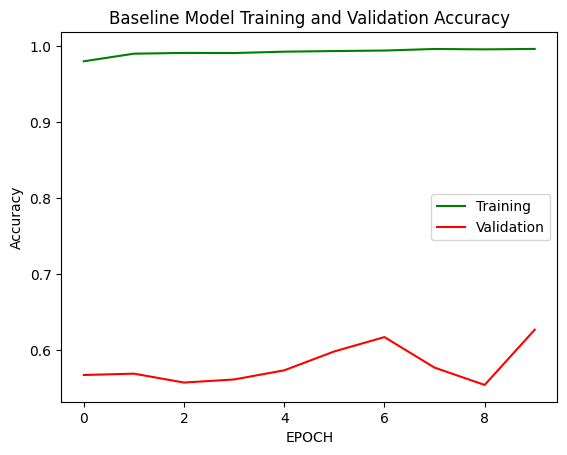

In [21]:
figTitle = './Figures/BL_tv_acc.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, blHistory["train"]["accuracy"], color = "green");
plt.plot(xAxis, blHistory["validation"]["accuracy"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title("Baseline Model Training and Validation Accuracy")
plt.savefig(figTitle)
plt.show()

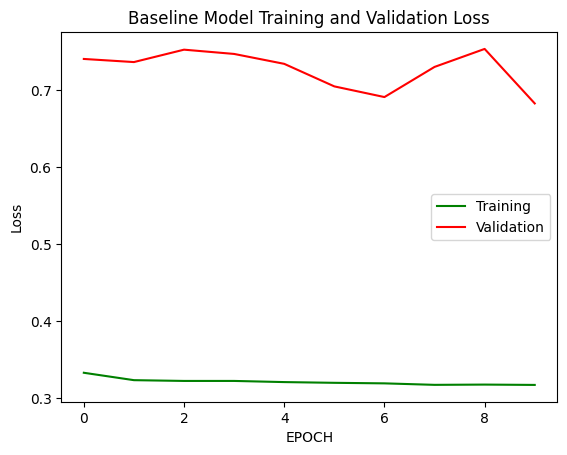

In [22]:
figTitle = './Figures/BL_tv_loss.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, blHistory["train"]["loss"], color = "green");
plt.plot(xAxis, blHistory["validation"]["loss"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title("Baseline Model Training and Validation Loss")
plt.savefig(figTitle)
plt.show()

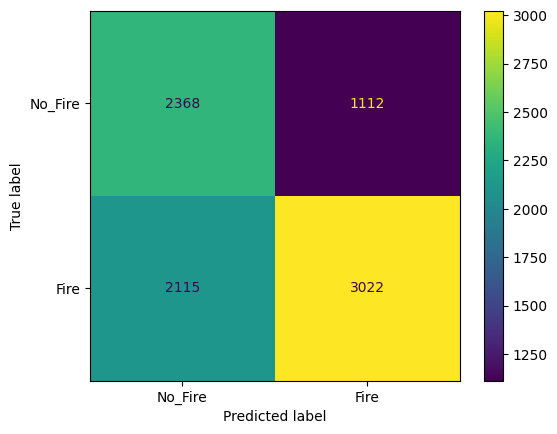

In [80]:
cfm = confusion_matrix(true_label, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

**Early Exiting Plots**

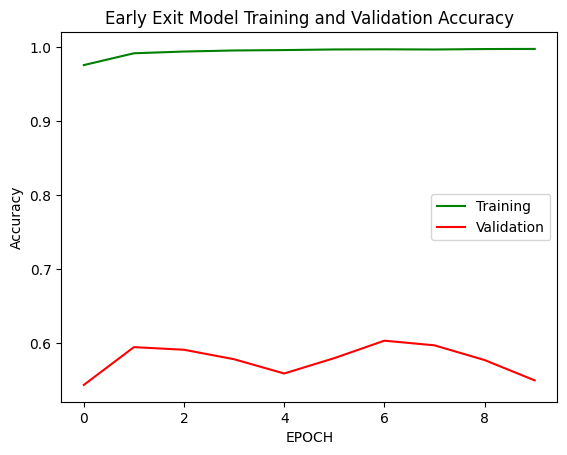

In [36]:
figTitle = './Figures/EE0_tv_acc.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, eeV0History['T']["train"]["accuracy"], color = "green");
plt.plot(xAxis, eeV0History['T']["validation"]["accuracy"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title("Early Exit Model Training and Validation Accuracy")
plt.savefig(figTitle)
plt.show()

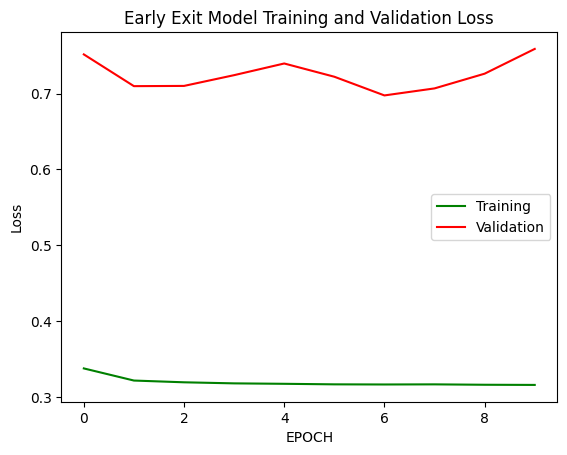

In [37]:
figTitle = './Figures/EE0_tv_loss.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, eeV0History['T']["train"]["loss"], color = "green");
plt.plot(xAxis, eeV0History['T']["validation"]["loss"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title("Early Exit Model Training and Validation Loss")
plt.savefig(figTitle)
plt.show()

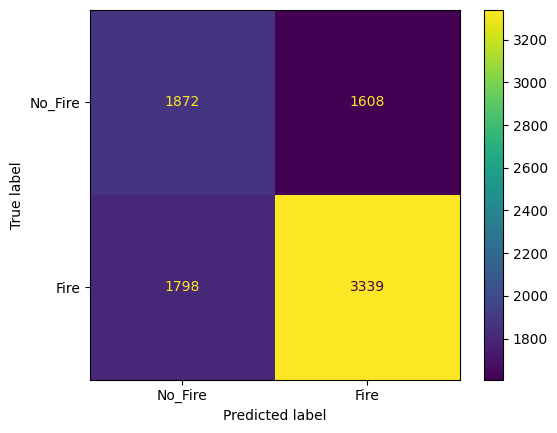

In [82]:
cfm = confusion_matrix(true_label, pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

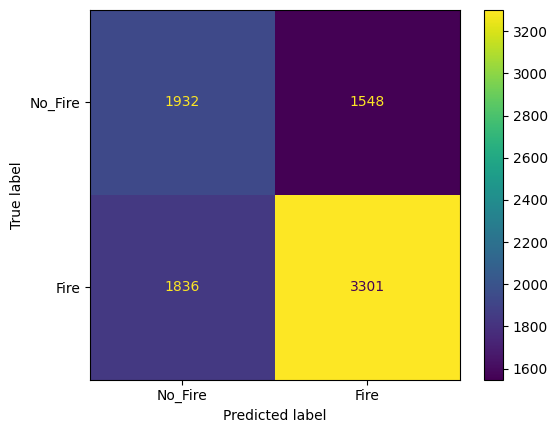

In [83]:
cfm = confusion_matrix(true_label, pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

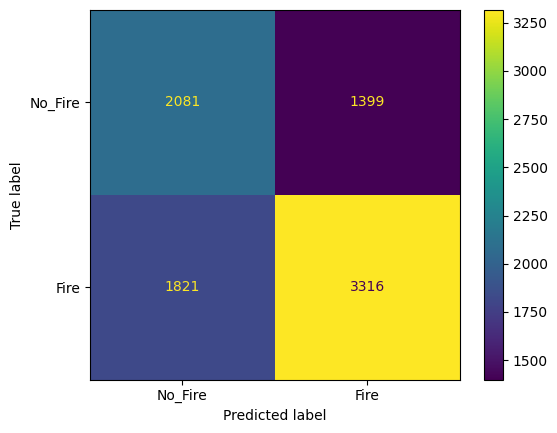

In [84]:
cfm = confusion_matrix(true_label, pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()